# Analysis of resutls

## Load data logged to wandb

In [1]:
import pandas as pd
import wandb

api = wandb.Api()
entity, project = "aleksandrabakalova", "coli-final"
runs = api.runs(entity + "/" + project)

tasks_is, seeds_is, test_results_is, tables_is = [], [], [], []
for run in runs:
    if "imp-scores" in run.name:
        summary = run.summary._json_dict
        test_results_is.append({
            "acc": summary["test_acc"],
            "loss": summary["test_loss"],
            "mse": summary["test_mse"]
        })

        tasks_is.append(run.name.split("-seed-")[0])
        seeds_is.append(run.name.split("-seed-")[1][:-len("-imp-scores")])

        art = api.artifact(f"aleksandrabakalova/coli-final/run-{run.id}-accs_with_removal:v0")
        table = art.get("accs_with_removal")
        tables_is.append(table.get_dataframe())

runs_is_df = pd.DataFrame(
    {"task": tasks_is, "seed": seeds_is, "test_results": test_results_is, "tables": tables_is}
)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [2]:
import pandas as pd
import wandb

api = wandb.Api()
entity, project = "aleksandrabakalova", "coli-final"
runs = api.runs(entity + "/" + project)

tasks, seeds, configs, run_results = [], [], [], []
for run in runs:
    if "imp-scores" not in run.name:
        summary = run.summary._json_dict
        run_results.append({
            "train_loss": summary["epoch/loss"],
            "val_loss": summary["epoch/val_loss"],
            "val_mse": summary["epoch/val_mse"],
            "val_acc": summary["epoch/acc"],
            "epochs": summary["epochs"],
        })
        configs.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        tasks.append(run.name.split("-seed-")[0])
        seeds.append(run.name.split("-seed-")[1])

runs_df = pd.DataFrame(
    {"results": run_results, "config": configs, "task": tasks, "seed": seeds}
)

In [3]:
merged = runs_df.merge(runs_is_df, on=["task", "seed"]);
merged = merged.set_index(["task", "seed"])

## Print the performance of fine-tuning

In [88]:
data = {"index": [ind for ind in merged.index],
        "columns": ["chance_performance", "test_accuracy", "epochs"],
        "data": [[f"{merged.loc[ind]['config']['chance_performance']:.2f}",
                  f"{merged.loc[ind]['test_results']['acc']:.2f}",
                  int(merged.loc[ind]["results"]["epochs"]) + 1] for ind in merged.index],
        "index_names": [None, None],
        "column_names": [None]}
# pd.DataFrame.from_dict(data, orient="tight")

## Importance scores graphs

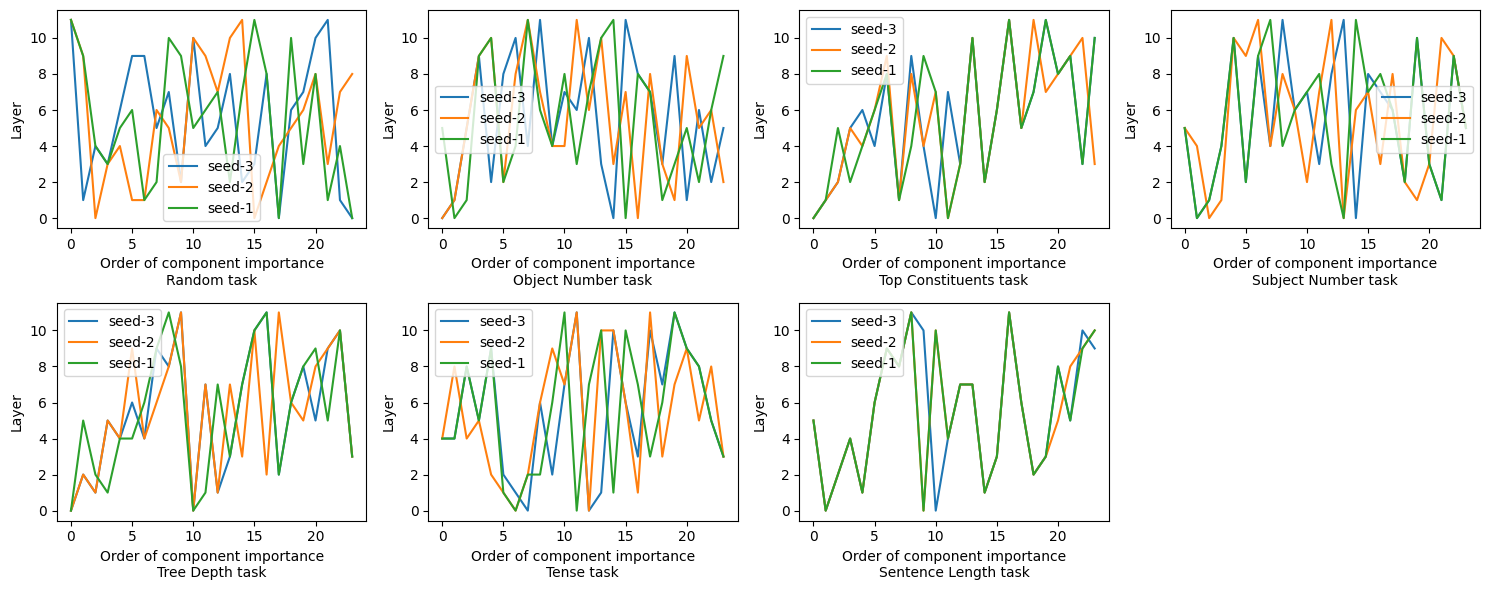

In [89]:
imp_scores_seqs = {
    ind: sorted([
    (merged.loc[ind]["tables"][["attn_loss", "mlp_loss"]].loc[layer, tp], (layer, tp))
    for layer in range(12)
    for tp in ["attn_loss", "mlp_loss"]
    ], key=lambda k: -k[0])
    for ind in merged.index
}

import matplotlib.pyplot as plt
all_tasks = sorted(list(set([task for task, seed in merged.index])), key=lambda t: t != "random")
all_tasks_to_ind = {task: i for i, task in enumerate(all_tasks)}

rows = 2
columns = 4
fig, axs = plt.subplots(rows, columns)
fig.set_size_inches((15, 6))
for ind in merged.index:
    axs[all_tasks_to_ind[ind[0]] // columns][all_tasks_to_ind[ind[0]] % columns].plot([layer for val, (layer, tp) in imp_scores_seqs[ind]], label=f"seed-{ind[1]}")
    axs[all_tasks_to_ind[ind[0]] // columns][all_tasks_to_ind[ind[0]] % columns].set_xlabel(
        f"Order of component importance\n{' '.join(map(lambda x : x.capitalize(), ind[0].split('_')))} task")
    axs[all_tasks_to_ind[ind[0]] // columns][all_tasks_to_ind[ind[0]] % columns].set_ylabel("Layer")
    axs[all_tasks_to_ind[ind[0]] // columns][all_tasks_to_ind[ind[0]] % columns].legend()
fig.delaxes(axs[-1][-1])
fig.tight_layout()
plt.savefig("dynamics_of_layers_of_importance_loss.png")
plt.show()

## Average correlations between and within tasks

In [90]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

imp_scores_seqs_unsorted = {
    ind: [
    (merged.loc[ind]["tables"][["attn_loss", "mlp_loss"]].loc[layer, tp], (layer, tp))
    for layer in range(12)
    for tp in ["attn_loss", "mlp_loss"]
    ]
    for ind in merged.index
}

all_tasks = sorted(list(set([task for task, seed in merged.index])), key=lambda t: t != "random")
corrs = {task: {"within": [], "between": []} for task in all_tasks}

for ind in merged.index:
    imp_score = [v for v, (layer, tp) in imp_scores_seqs_unsorted[ind]]
    for other_ind in merged.index:
        if ind == other_ind:
            continue
        other_imp_score = [v for v, (layer, tp) in imp_scores_seqs_unsorted[other_ind]]
        if ind[0] == other_ind[0]:
            corrs[ind[0]]["within"].append(pearsonr(imp_score, other_imp_score).statistic)
        else:
            corrs[ind[0]]["between"].append(pearsonr(imp_score, other_imp_score).statistic)

data = {"index": [" ".join(map(lambda x : x.capitalize(), task.split("_"))) for task in all_tasks],
        "columns": ["Within task", "Between tasks"],
        "data": [[f"{np.array(corrs[task]['within']).mean():.2f}", f"{np.array(corrs[task]['between']).mean():.2f}"] for task in all_tasks],
        "index_names": [None],
        "column_names": [None]}
pd.DataFrame.from_dict(data, orient="tight")

,Within task,Between tasks
Random,0.87,0.04
Object Number,0.91,0.59
Top Constituents,1.00,0.64
Subject Number,0.96,0.58
Tree Depth,0.99,0.67
Tense,0.98,0.38
Sentence Length,1.00,0.70


## Average correaltions between tasks

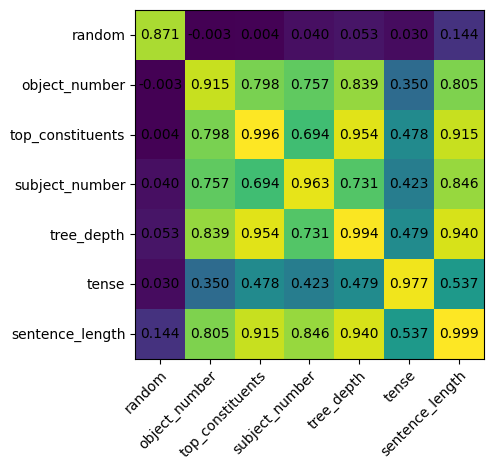

In [91]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

all_tasks = sorted(list(set([task for task, seed in merged.index])), key=lambda t: t != "random")
task_to_id = {task : id for id, task in enumerate(all_tasks)}
corrs = np.zeros((len(all_tasks), len(all_tasks)))

for ind in merged.index:
    imp_score = [v for v, (layer, tp) in imp_scores_seqs_unsorted[ind]]
    for other_ind in merged.index:
        if ind == other_ind:
            continue
        other_imp_score = [v for v, (layer, tp) in imp_scores_seqs_unsorted[other_ind]]
        corrs[task_to_id[ind[0]]][task_to_id[other_ind[0]]] += pearsonr(imp_score, other_imp_score).statistic
corrs = corrs / 9
corrs[np.arange(corrs.shape[0]), np.arange(corrs.shape[0])] = corrs[np.arange(corrs.shape[0]), np.arange(corrs.shape[0])] * 9 / 6

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1)
axs.imshow(corrs)
for k in range(corrs.shape[0]):
    for l in range(corrs.shape[1]):
        axs.text(l, k, f"{corrs[k,l]:.3f}", ha="center", va="center", color="black", fontsize=10)
axs.set_xticks(np.arange(len(all_tasks)), labels=all_tasks, fontsize=10)
axs.set_yticks(np.arange(len(all_tasks)), labels=all_tasks, fontsize=10)
plt.setp(axs.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
plt.savefig("correlations_loss.png")
plt.show()

## Top-n important components for each task

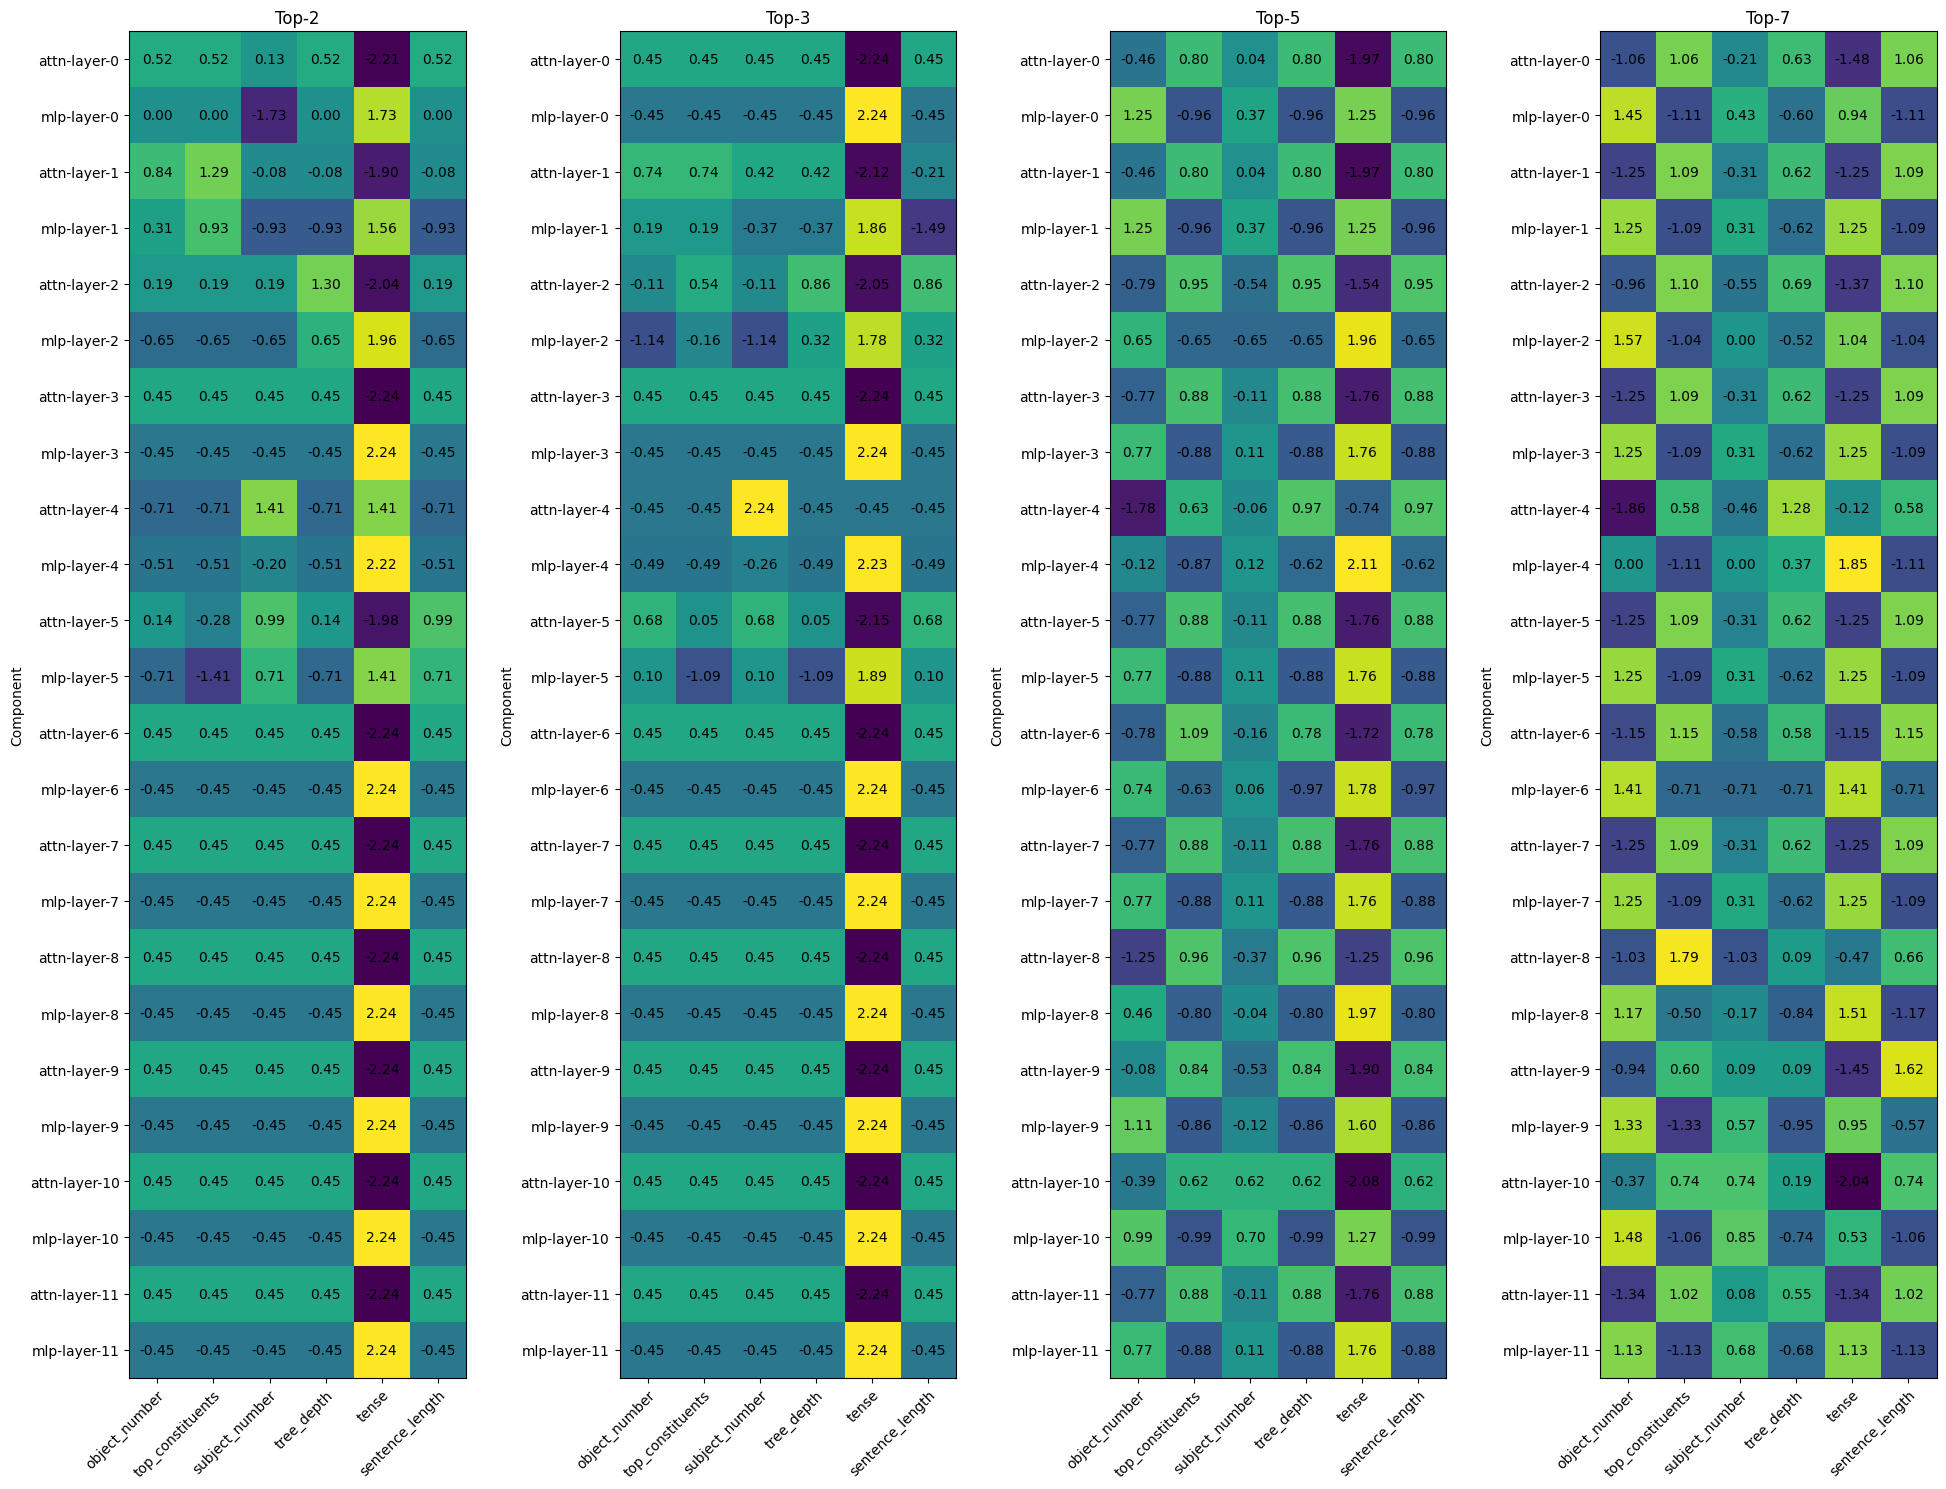

In [110]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from scipy.stats import zscore

all_tasks = list(set([task for task, seed in merged.index if task != "random"]))
top = [2, 3, 5, 7]
imp_comps = [np.zeros((24, len(all_tasks))) for _ in range(len(top))]
for top_i, top_k in enumerate(top):
    for layer in range(12):
        for tp_i, tp in enumerate(["attn_loss", "mlp_loss"]):
            for task_i, task in enumerate(all_tasks):
                imp_comps[top_i][layer*2+tp_i, task_i] = sum([(np.array([(l, t) for v, (l, t) in imp_scores_seqs[(task, seed)]][:top_k]) == (layer, tp)).sum() for seed in ["1", "2", "3"]])
            if (imp_comps[top_i][layer*2+tp_i] == imp_comps[top_i][layer*2+tp_i, 0]).all():
                imp_comps[top_i][layer*2+tp_i] = np.zeros(len(all_tasks))
            else:
                imp_comps[top_i][layer*2+tp_i] = zscore(imp_comps[top_i][layer*2+tp_i])

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(top))
fig.set_size_inches((20, 15))
for top_i, top_k in enumerate(top):
    axs[top_i].imshow(imp_comps[top_i])
    for k in range(imp_comps[top_i].shape[0]):
        for l in range(imp_comps[top_i].shape[1]):
            axs[top_i].text(l, k, f"{imp_comps[top_i][k,l]:.2f}", ha="center", va="center", color="black", fontsize=10)
    axs[top_i].set_xticks(np.arange(len(all_tasks)), labels=all_tasks, fontsize=10)
    axs[top_i].set_yticks(np.arange(24), labels=[f"{tp[:-len('_loss')]}-layer-{l}" for l in range(12) for tp in ["attn_loss", "mlp_loss"]], fontsize=10)
    plt.setp(axs[top_i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axs[top_i].set_ylabel("Component")
    axs[top_i].set_title(f"Top-{top_k}")
fig.tight_layout()
plt.savefig("component_top_k_importance.png")
plt.show()

## Top-n important layers

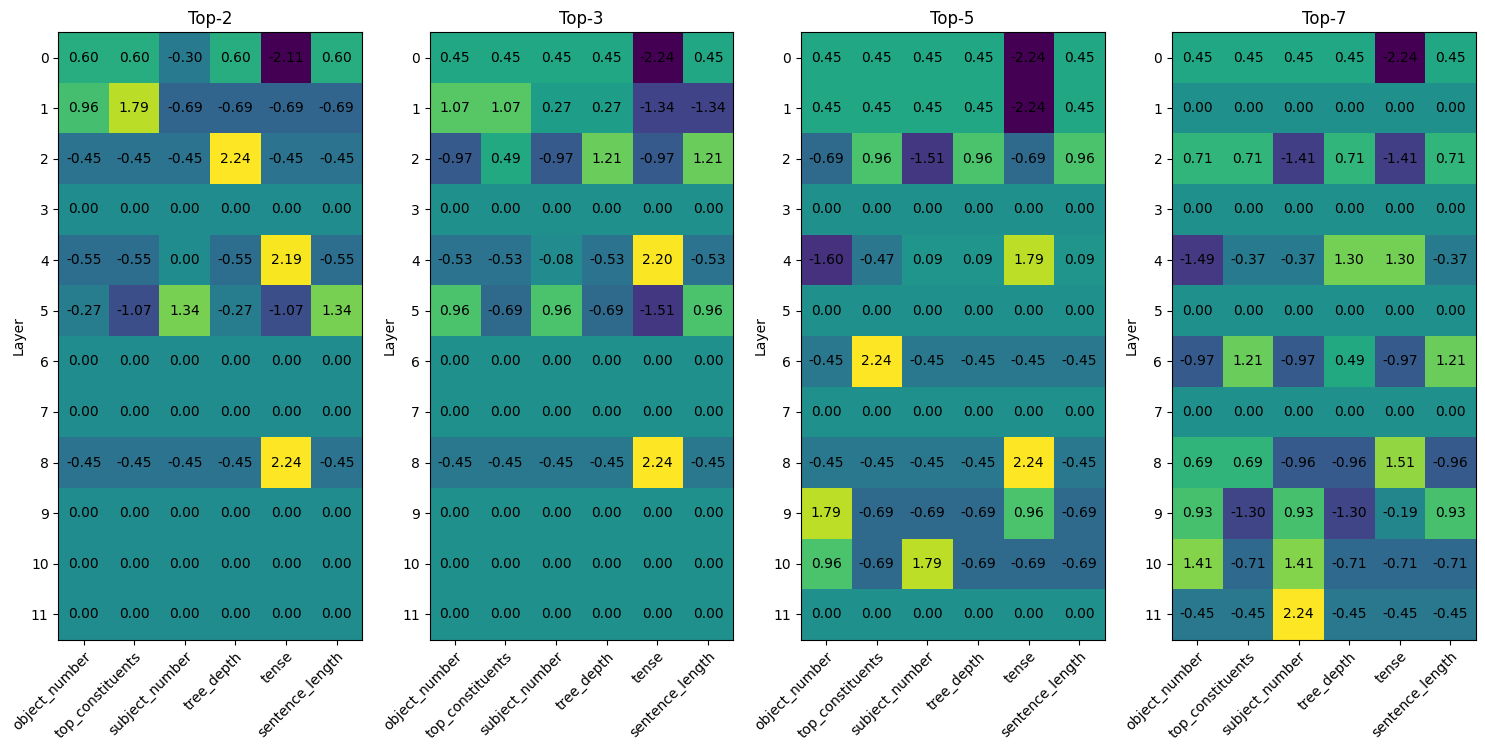

In [92]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from scipy.stats import zscore

all_tasks = list(set([task for task, seed in merged.index if task != "random"]))
top = [2, 3, 5, 7]
imp_layers = [np.zeros((12, len(all_tasks))) for _ in range(len(top))]
for top_i, top_k in enumerate(top):
    for layer in range(12):
        for task_i, task in enumerate(all_tasks):
            imp_layers[top_i][layer, task_i] = sum([(np.array([l for v, (l, tp) in imp_scores_seqs[(task, seed)]][:top_k]) == layer).sum() for seed in ["1", "2", "3"]])
        if (imp_layers[top_i][layer] == imp_layers[top_i][layer, 0]).all():
            imp_layers[top_i][layer] = np.zeros(len(all_tasks))
        else:
            imp_layers[top_i][layer] = zscore(imp_layers[top_i][layer])

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(top))
fig.set_size_inches((15, 8))
for top_i, top_k in enumerate(top):
    axs[top_i].imshow(imp_layers[top_i])
    for k in range(imp_layers[top_i].shape[0]):
        for l in range(imp_layers[top_i].shape[1]):
            axs[top_i].text(l, k, f"{imp_layers[top_i][k,l]:.2f}", ha="center", va="center", color="black", fontsize=10)
    axs[top_i].set_xticks(np.arange(len(all_tasks)), labels=all_tasks, fontsize=10)
    axs[top_i].set_yticks(np.arange(12), labels=np.arange(12), fontsize=10)
    plt.setp(axs[top_i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axs[top_i].set_ylabel("Layer")
    axs[top_i].set_title(f"Top-{top_k}")
fig.tight_layout()
plt.savefig("zscore_on_layers_imp.png")
plt.show()

## Component importance ranks

In [93]:
imp_scores_seqs = {
    ind: sorted([
    (merged.loc[ind]["tables"][["attn_loss", "mlp_loss"]].loc[layer, tp], (layer, tp))
    for layer in range(12)
    for tp in ["attn_loss", "mlp_loss"]
    ], key=lambda k: -k[0])
    for ind in merged.index
}
comp_to_imp_score = {ind: {(l, t): i for i, (v, (l, t)) in enumerate(imp_scores_seqs[ind])} for ind in merged.index}

all_tasks = sorted(list(set([task for task, seed in merged.index])), key=lambda t: t != "random")
imp_for_components = {}

for layer in range(12):
    for tp in ["attn_loss", "mlp_loss"]:
        imp_for_components[f"{tp[:-len('_loss')]}-layer-{layer}"] = {task: np.mean([comp_to_imp_score[(task, seed)][(layer, tp)] for seed in ["1", "2", "3"]]) for task in all_tasks}

imps = [[imp_for_components[comp][task] for task in imp_for_components[comp]] for comp in imp_for_components]
for comp_i, comp in enumerate(imp_for_components):
    for task_i, task in enumerate(imp_for_components[comp]):
        imp_for_task = np.array([imp_for_components[c][task] for c in imp_for_components])
        if sum(imp_for_task <= imp_for_components[comp][task]) <= 5:
            imps[comp_i][task_i] = f"\\textbf{{{imps[comp_i][task_i]:.2f}}}"
        elif sum(imp_for_task <= imp_for_components[comp][task]) <= 10:
            imps[comp_i][task_i] = f"\\textit{{\\textbf{{{imps[comp_i][task_i]:.2f}}}}}"
        else:
            imps[comp_i][task_i] = f"{imps[comp_i][task_i]:.2f}"
data = {"index": imp_for_components,
        "columns": [" ".join(map(lambda x: x.capitalize(), task.split("_"))) for task in all_tasks],
        "data": imps,
        "index_names": [None],
        "column_names": [None]}
pd.DataFrame.from_dict(data, orient="tight")

,Random,Object Number,Top Constituents,Subject Number,Tree Depth,Tense,Sentence Length
attn-layer-0,14.00,\textbf{0.33},\textbf{0.00},\textbf{1.33},\textbf{0.00},\textit{\textbf{6.33}},\textbf{1.00}
mlp-layer-0,18.33,15.00,10.67,13.33,10.00,11.67,\textit{\textbf{9.33}}
attn-layer-1,16.00,\textbf{1.33},\textbf{1.00},\textbf{2.33},\textbf{2.33},\textbf{5.33},\textbf{4.00}
mlp-layer-1,\textbf{4.33},19.00,\textit{\textbf{7.00}},20.33,11.67,14.33,14.00
attn-layer-2,\textit{\textbf{10.00}},\textit{\textbf{4.67}},\textbf{2.33},\textit{\textbf{6.67}},\textbf{1.33},\textit{\textbf{5.67}},\textbf{2.00}
mlp-layer-2,12.67,22.00,14.00,18.00,16.67,\textit{\textbf{7.67}},18.00
attn-layer-3,18.33,12.67,12.00,20.00,13.33,17.00,15.00
mlp-layer-3,\textbf{3.00},18.33,22.33,13.00,23.00,23.00,19.00
attn-layer-4,\textbf{2.67},\textit{\textbf{8.00}},\textbf{4.33},\textbf{2.33},\textbf{4.00},\textbf{1.33},\textbf{3.00}
mlp-layer-4,16.67,\textit{\textbf{8.67}},\textit{\textbf{8.67}},\textit{\textbf{7.33}},\textit{\textbf{5.67}},\textbf{0.00},11.00


## Top-n important layers

In [102]:
import numpy as np
top = [2, 3, 5, 7]
all_tasks = sorted(list(set([task for task, seed in merged.index])), key=lambda t: t != "random")
all_seeds = sorted(list(set([seed for task, seed in merged.index])))
inds_for_table = [(task, seed) for task in all_tasks for seed in all_seeds + ["average"]]
inds_for_table_name = [(" ".join(map(lambda x : x.capitalize(), task.split("_"))), seed) for task in all_tasks for seed in all_seeds + ["average"]]
data = {"index": inds_for_table_name,
        "columns": [(f"Top-{top_k}", tp) for top_k in top for tp in ["avg", "std"]],
        "data": [([f"{foo([layer for val, (layer, tp) in imp_scores_seqs[ind][:top_k]]):.2f}" for top_k in top for foo in [np.mean, np.std]] if ind[1] != "average" else
                  [f"{foo([[layer for val, (layer, tp) in imp_scores_seqs[cur_ind][:top_k]] for cur_ind in [(ind[0], seed) for seed in all_seeds]]):.2f}"
                   for top_k in top for foo in [np.mean, np.std]])
                 for ind in inds_for_table],
        "index_names": [None, None],
        "column_names": [None, None]}
pd.DataFrame.from_dict(data, orient="tight")

Top-2       Top-3       Top-5       Top-7      
                            avg   std   avg   std   avg   std   avg   std
Random           1        10.00  1.00  8.00  2.94  6.40  3.07  5.57  3.20
                 2        10.00  1.00  6.67  4.78  5.40  4.03  4.14  3.94
                 3         6.00  5.00  5.33  4.19  5.00  3.41  6.14  3.40
                 average   8.67  3.54  6.67  4.19  5.60  3.57  5.29  3.63
Object Number    1         2.50  2.50  2.00  2.16  5.00  4.05  4.43  3.58
                 2         0.50  0.50  2.00  2.16  5.00  4.05  5.00  3.78
                 3         0.50  0.50  2.00  2.16  3.40  3.26  5.00  3.78
                 average   1.17  1.77  2.00  2.16  4.47  3.88  4.81  3.72
Top Constituents 1         0.50  0.50  2.00  2.16  2.40  1.85  3.71  2.66
                 2         0.50  0.50  1.00  0.82  2.40  1.85  3.86  2.90
                 3         0.50  0.50  1.00  0.82  2.80  2.32  3.71  2.66
                 average   0.50  0.50  1.33  1.49  2.53  2.03  3.76  2.74
Subject Number   1         2.50  2.50  2.00  2.16  4.00  3.52  4.43  3.58
                 2         4.50  0.50  3.00  2.16  4.00  3.52  5.71  4.06
                 3         2.50  2.50  2.00  2.16  4.00  3.52  4.43  3.58
                 average   3.17  2.27  2.33  2.21  4.00  3.52  4.86  3.80
Tree Depth       1         2.50  2.50  2.33  2.05  2.40  1.85  3.14  2.03
                 2         1.00  1.00  1.00  0.82  2.40  1.85  3.57  2.77
                 3         1.00  1.00  1.00  0.82  2.40  1.85  3.14  2.03
                 average   1.50  1.80  1.44  1.50  2.40  1.85  3.29  2.31
Tense            1         4.00  0.00  5.33  1.89  6.00  2.10  4.43  3.06
                 2         6.00  2.00  5.33  1.89  4.60  1.96  3.43  2.50
                 3         4.00  0.00  5.33  1.89  6.00  2.10  4.71  2.71
                 average   4.67  1.49  5.33  1.89  5.53  2.16  4.19  2.82
Sentence Length  1         2.50  2.50  2.33  2.05  2.40  1.85  3.86  2.90
                 2         2.50  2.50  2.33  2.05  2.40  1.85  3.86  2.90
                 3         2.50  2.50  2.33  2.05  2.40  1.85  3.86  2.90
                 average   2.50  2.50  2.33  2.05  2.40  1.85  3.86  2.90

## When the importance scores start to be different

In [111]:
all_tasks = list(set([task for task, seed in merged.index]))
all_tasks_to_ind = {task: i for i, task in enumerate(all_tasks)}
first_difference_between_seeds = {task: None for task in all_tasks}
scores = {task: [] for task in all_tasks}
for ind in merged.index:
    scores[ind[0]].append(np.array([layer for val, (layer, tp) in imp_scores_seqs[ind]]))
first_difference_between_seeds = {task: np.argmin((scores[task][0] == scores[task][1]) & (scores[task][0] == scores[task][2])) for task in all_tasks}
first_difference_between_seeds

{'object_number': 0,
 'top_constituents': 2,
 'subject_number': 1,
 'tree_depth': 1,
 'tense': 1,
 'random': 1,
 'sentence_length': 9}